# Measuring accuracy of XGBoost models 
(using stratified 5-fold cross validation, and a model with 8 features)

## Plain English summary

We have decided to simplify our model by using 8 independent features to predict which patients recieve thrombolysis. These are: arrival-to-scan time, infarction, stroke severity, precise onset time, prior disability level, stroke team, use of AF anticoagulents, and onset-to-arrival time. This gives a good balance of performance (in terms of ROC AUC, achieving 99.1% of what can be obtained with all 84 features) and model complexity. 

There are many other ways in which to report model performance - in this notebook we will report on a range of these. The overall model accuracy is 84.7%, so just over 8 out of 10 instances will have a correct prediction. The model is also well calibrated (for example, all of the patients that a model predicts 40% probability for, 40% of them did recieve it).

## Model and data

XGBoost models were trained on stratified k-fold cross-validation data. The 8 features in the model are:

* Arrival-to-scan time: Time from arrival at hospital to scan (mins)
* Infarction: Stroke type (1 = infarction, 0 = haemorrhage)
* Stroke severity: Stroke severity (NIHSS) on arrival
* Precise onset time: Onset time type (1 = precise, 0 = best estimate)
* Prior disability level: Disability level (modified Rankin Scale) before stroke
* Stroke team: Stroke team attended
* Use of AF anticoagulents: Use of atrial fibrillation anticoagulant (1 = Yes, 0 = No)
* Onset-to-arrival time: Time from onset of stroke to arrival at hospital (mins)

And one target feature:
* Thrombolysis: Recieve thrombolysis (1 = Yes, 0 = No)

The 8 features included in the model (to predict whether a patient will recieve thrombolysis) were chosen sequentially as having the single best improvement in model performance (using the ROC AUC). The stroke team feature is included as a one-hot encoded feature.

## Aims

* Measure a range of accuracy scores (e.g. accuracy, sensitivity, specificity, F1, etc).
* Plot Receiver Operator Characteristic Curve and measure AUC.
* Identify cross-over point of sensitivity and specificity.
* Save individual patient predictions.
* Compare predicted and observed thrombolysis use at each hospital.
* Examine learning curves
* Check model calibration.

## Observations

* Overall accuracy = 84.8% (88.3 for those 69% samples with at least 80% confidence of model)
* Using nominal threshold (50% probability), specificity (89.4%) is greater than sensitivity (73.8%)
* The model can achieve 83.8% sensitivity and specificity simultaneously
* ROC AUC = 0.916
* The model is well calibrated

## Import libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd

from xgboost import XGBClassifier
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.linear_model import LinearRegression
from sklearn import metrics

from imblearn.over_sampling import RandomOverSampler

import json

## Set modifications to apply

In [2]:
use_minority_oversampling = False

# Set model type (used in file save, e.g. xgb_combined_calibrated_oversampled)
model_type = 'xgb_combined_key_features'

## Create output folders if needed

In [3]:
path = './output'
if not os.path.exists(path):
    os.makedirs(path)
    
path = './predictions'
if not os.path.exists(path):
    os.makedirs(path)

## Read in JSON file

Contains a dictionary for plain English feature names for the 8 features selected in the model. Use these as the column titles in the DataFrame.

In [4]:
with open("./output/feature_name_dict.json") as json_file:
    feature_name_dict = json.load(json_file)

## Load data

Data has previously been split into 5 stratified k-fold splits.

In [5]:
data_loc = '../data/kfold_5fold/'

In [6]:
# Initialise empty lists
train_data, test_data = [], []

# Read in the names of the selected features for the model
number_of_features_to_use = 8
key_features = pd.read_csv('./output/feature_selection.csv')
key_features = list(key_features['feature'])[:number_of_features_to_use]
# And add the target feature name: S2Thrombolysis
key_features.append("S2Thrombolysis")

for i in range(5):
    train = pd.read_csv(data_loc + 'train_{0}.csv'.format(i))
    train = train[key_features]
    train.rename(columns=feature_name_dict, inplace=True)
    train_data.append(train)
    test = pd.read_csv(data_loc + 'test_{0}.csv'.format(i))
    test = test[key_features]
    test.rename(columns=feature_name_dict, inplace=True)
    test_data.append(test)

## Functions 

### Calculate accuracy measures

In [7]:
def calculate_accuracy(observed, predicted):
    
    """
    Calculates a range of accuracy scores from observed and predicted classes.
    
    Takes two list or NumPy arrays (observed class values, and predicted class 
    values), and returns a dictionary of results.
    
     1) observed positive rate: proportion of observed cases that are +ve
     2) Predicted positive rate: proportion of predicted cases that are +ve
     3) observed negative rate: proportion of observed cases that are -ve
     4) Predicted negative rate: proportion of predicted cases that are -ve  
     5) accuracy: proportion of predicted results that are correct    
     6) precision: proportion of predicted +ve that are correct
     7) recall: proportion of true +ve correctly identified
     8) f1: harmonic mean of precision and recall
     9) sensitivity: Same as recall
    10) specificity: Proportion of true -ve identified:        
    11) positive likelihood: increased probability of true +ve if test +ve
    12) negative likelihood: reduced probability of true +ve if test -ve
    13) false positive rate: proportion of false +ves in true -ve patients
    14) false negative rate: proportion of false -ves in true +ve patients
    15) true positive rate: Same as recall
    16) true negative rate: Same as specificity
    17) positive predictive value: chance of true +ve if test +ve
    18) negative predictive value: chance of true -ve if test -ve
    
    """
    
    # Converts list to NumPy arrays
    if type(observed) == list:
        observed = np.array(observed)
    if type(predicted) == list:
        predicted = np.array(predicted)
    
    # Calculate accuracy scores
    observed_positives = observed == 1
    observed_negatives = observed == 0
    predicted_positives = predicted == 1
    predicted_negatives = predicted == 0
    
    true_positives = (predicted_positives == 1) & (observed_positives == 1)
    
    false_positives = (predicted_positives == 1) & (observed_positives == 0)
    
    true_negatives = (predicted_negatives == 1) & (observed_negatives == 1)
    
    false_negatives = (predicted_negatives == 1) & (observed_negatives == 0)
    
    accuracy = np.mean(predicted == observed)
    
    precision = (np.sum(true_positives) /
                 (np.sum(true_positives) + np.sum(false_positives)))
        
    recall = np.sum(true_positives) / np.sum(observed_positives)
    
    sensitivity = recall
    
    f1 = 2 * ((precision * recall) / (precision + recall))
    
    specificity = np.sum(true_negatives) / np.sum(observed_negatives)
    
    positive_likelihood = sensitivity / (1 - specificity)
    
    negative_likelihood = (1 - sensitivity) / specificity
    
    false_positive_rate = 1 - specificity
    
    false_negative_rate = 1 - sensitivity
    
    true_positive_rate = sensitivity
    
    true_negative_rate = specificity
    
    positive_predictive_value = (np.sum(true_positives) / 
                            (np.sum(true_positives) + np.sum(false_positives)))
    
    negative_predictive_value = (np.sum(true_negatives) / 
                            (np.sum(true_negatives) + np.sum(false_negatives)))
    
    # Create dictionary for results, and add results
    results = dict()
    
    results['observed_positive_rate'] = np.mean(observed_positives)
    results['observed_negative_rate'] = np.mean(observed_negatives)
    results['predicted_positive_rate'] = np.mean(predicted_positives)
    results['predicted_negative_rate'] = np.mean(predicted_negatives)
    results['accuracy'] = accuracy
    results['precision'] = precision
    results['recall'] = recall
    results['f1'] = f1
    results['sensitivity'] = sensitivity
    results['specificity'] = specificity
    results['positive_likelihood'] = positive_likelihood
    results['negative_likelihood'] = negative_likelihood
    results['false_positive_rate'] = false_positive_rate
    results['false_negative_rate'] = false_negative_rate
    results['true_positive_rate'] = true_positive_rate
    results['true_negative_rate'] = true_negative_rate
    results['positive_predictive_value'] = positive_predictive_value
    results['negative_predictive_value'] = negative_predictive_value
    
    return results

## Fit model

XGBoost models were trained on stratified k-fold cross-validation data

In [8]:
# Set up list to store models and calibarion threshold
models = []

# Set up lists for observed and predicted
observed = []
predicted_proba = []
predicted = []

# Set up list for feature importances
feature_importance = []

# Loop through k folds
for k_fold in range(5):
    
    # Get k fold split
    train = train_data[k_fold]
    test = test_data[k_fold]
    
    # Get X and y
    X_train = train.drop("Thrombolysis", axis=1)
    X_test = test.drop("Thrombolysis", axis=1)
    y_train = train["Thrombolysis"]
    y_test = test["Thrombolysis"]
    
    # Use oversampling if required
    if use_minority_oversampling:
        oversample = RandomOverSampler(sampling_strategy='minority')
        X_train, y_train = oversample.fit_resample(X_train, y_train)        
    
    # One hot encode hospitals
    X_train_hosp = pd.get_dummies(X_train['Stroke team'], prefix = 'team')
    X_train = pd.concat([X_train, X_train_hosp], axis=1)
    X_train.drop('Stroke team', axis=1, inplace=True)
    X_test_hosp = pd.get_dummies(X_test['Stroke team'], prefix = 'team')
    X_test = pd.concat([X_test, X_test_hosp], axis=1)
    X_test.drop('Stroke team', axis=1, inplace=True)    
    
    # Define model
    model = XGBClassifier(verbosity = 0, seed=42, learning_rate=0.5)
    
    # Fit model
    model.fit(X_train, y_train)
    models.append(model)
    
    # Get predicted probabilities
    y_probs = model.predict_proba(X_test)[:,1]
    observed.append(y_test)
    predicted_proba.append(y_probs)
    
    # Get feature importances
    importance = model.feature_importances_
    feature_importance.append(importance)
    
    # Get class
    y_class = y_probs >= 0.5
    y_class = np.array(y_class) * 1.0
    predicted.append(y_class)
    
    # Print accuracy
    accuracy = np.mean(y_class == y_test)
    print (
        f'Run {k_fold}, accuracy: {accuracy:0.3f}')

Run 0, accuracy: 0.846
Run 1, accuracy: 0.852
Run 2, accuracy: 0.845
Run 3, accuracy: 0.851
Run 4, accuracy: 0.845


## Results 

### Accuracy measures 

In [9]:
# Set up list for results
k_fold_results = []

# Loop through k fold predictions and get accuracy measures
for i in range(5):
    results = calculate_accuracy(observed[i], predicted[i])
    k_fold_results.append(results)
    
# Put results in DataFrame
accuracy_results = pd.DataFrame(k_fold_results).T

In [10]:
accuracy_results

,0,1,2,3,4
observed_positive_rate,0.295963,0.295737,0.295867,0.295529,0.295472
observed_negative_rate,0.704037,0.704263,0.704133,0.704471,0.704528
predicted_positive_rate,0.290388,0.291852,0.294853,0.292488,0.295022
predicted_negative_rate,0.709612,0.708148,0.705147,0.707512,0.704978
accuracy,0.846444,0.851850,0.844577,0.851109,0.845365
precision,0.745201,0.752846,0.738159,0.750674,0.738691
recall,0.731164,0.742955,0.735630,0.742950,0.737564
f1,0.738116,0.747868,0.736892,0.746792,0.738127
sensitivity,0.731164,0.742955,0.735630,0.742950,0.737564
specificity,0.894905,0.897577,0.890355,0.896483,0.890576


In [11]:
accuracy_results.T.describe().T

,count,mean,std,min,25%,50%,75%,max
observed_positive_rate,5.0,0.295714,0.000211,0.295472,0.295529,0.295737,0.295867,0.295963
observed_negative_rate,5.0,0.704286,0.000211,0.704037,0.704133,0.704263,0.704471,0.704528
predicted_positive_rate,5.0,0.292921,0.001993,0.290388,0.291852,0.292488,0.294853,0.295022
predicted_negative_rate,5.0,0.707079,0.001993,0.704978,0.705147,0.707512,0.708148,0.709612
accuracy,5.0,0.847869,0.003372,0.844577,0.845365,0.846444,0.851109,0.851850
precision,5.0,0.745114,0.006714,0.738159,0.738691,0.745201,0.750674,0.752846
recall,5.0,0.738053,0.005039,0.731164,0.735630,0.737564,0.742950,0.742955
f1,5.0,0.741559,0.005306,0.736892,0.738116,0.738127,0.746792,0.747868
sensitivity,5.0,0.738053,0.005039,0.731164,0.735630,0.737564,0.742950,0.742955
specificity,5.0,0.893979,0.003346,0.890355,0.890576,0.894905,0.896483,0.897577


### Receiver Operator Characteristic and Sensitivity-Specificity Curves

Receiver Operator Characteristic Curve:

In [12]:
# Set up lists for results
k_fold_fpr = [] # false positive rate
k_fold_tpr = [] # true positive rate
k_fold_thresholds = [] # threshold applied
k_fold_auc = [] # area under curve

# Loop through k fold predictions and get ROC results 
for i in range(5):
    fpr, tpr, thresholds = roc_curve(observed[i], predicted_proba[i])
    roc_auc = auc(fpr, tpr)
    k_fold_fpr.append(fpr)
    k_fold_tpr.append(tpr)
    k_fold_thresholds.append(thresholds)
    k_fold_auc.append(roc_auc)

# Show mean area under curve  
mean_auc = np.mean(k_fold_auc)
sd_auc = np.std(k_fold_auc)
print (f'\nMean AUC: {mean_auc:0.4f}')
print (f'SD AUC: {sd_auc:0.4f}')


Mean AUC: 0.9162
SD AUC: 0.0024


Calculate data for sensitivity-specificity curve:

In [13]:
k_fold_sensitivity = []
k_fold_specificity = []


for i in range(5):
    # Get classificiation probabilities for k-fold replicate
    obs = observed[i]
    proba = predicted_proba[i]
    
    # Set up list for accuracy measures
    sensitivity = []
    specificity = []
    
    # Loop through increments in probability of survival
    thresholds = np.arange(0.0, 1.01, 0.01)
    for cutoff in thresholds: #  loop 0 --> 1 on steps of 0.1
        # Get classificiation using cutoff
        predicted_class = proba >= cutoff
        predicted_class = predicted_class * 1.0
        # Call accuracy measures function
        accuracy = calculate_accuracy(obs, predicted_class)
        # Add accuracy scores to lists
        sensitivity.append(accuracy['sensitivity'])
        specificity.append(accuracy['specificity'])
    
    # Add replicate to lists
    k_fold_sensitivity.append(sensitivity)
    k_fold_specificity.append(specificity)

Create a combined plot: ROC and sensitivity-specificity

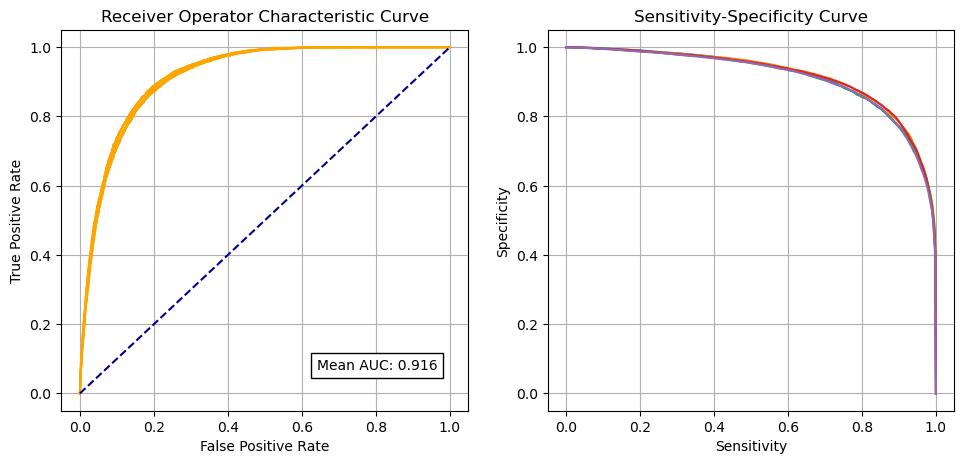

In [14]:
fig = plt.figure(figsize=(10,5))

# Plot ROC
ax1 = fig.add_subplot(121)
for i in range(5):
    ax1.plot(k_fold_fpr[i], k_fold_tpr[i], color='orange')
ax1.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operator Characteristic Curve')
text = f'Mean AUC: {mean_auc:.3f}'
ax1.text(0.64,0.07, text, 
         bbox=dict(facecolor='white', edgecolor='black'))
plt.grid(True)

# Plot sensitivity-specificity
ax2 = fig.add_subplot(122)
for i in range(5):
    ax2.plot(k_fold_sensitivity[i], k_fold_specificity[i])
ax2.set_xlabel('Sensitivity')
ax2.set_ylabel('Specificity')
ax2.set_title('Sensitivity-Specificity Curve')
plt.grid(True)


plt.tight_layout(pad=2)
plt.savefig(f'./output/{model_type}_roc_sens_spec.jpg', dpi=300)

plt.show()

### Identify cross-over point on sensitivity-specificity curve

Adjusting the classification threshold allows us to balance sensitivity (the proportion of patients receiving thrombolysis correctly identified) and specificity (the proportion of patients *not* receiving thrombolysis correctly identified). An increase in sensitivity causes a loss in specificity (and vice versa). Here we identify the pint where specificity and sensitivity hold the same value.

In [15]:
def get_intersect(a1, a2, b1, b2):
    """ 
    Returns the point of intersection of the lines passing through a2,a1 and b2,b1.
    a1: [x, y] a point on the first line
    a2: [x, y] another point on the first line
    b1: [x, y] a point on the second line
    b2: [x, y] another point on the second line
    """
    s = np.vstack([a1,a2,b1,b2])        # s for stacked
    h = np.hstack((s, np.ones((4, 1)))) # h for homogeneous
    l1 = np.cross(h[0], h[1])           # get first line
    l2 = np.cross(h[2], h[3])           # get second line
    x, y, z = np.cross(l1, l2)          # point of intersection
    if z == 0:                          # lines are parallel
        return (float('inf'), float('inf'))
    return (x/z, y/z)

In [16]:
intersections = []
for i in range(5):
    sens = np.array(k_fold_sensitivity[i])
    spec = np.array(k_fold_specificity[i])
    df = pd.DataFrame()
    df['sensitivity'] = sens
    df['specificity'] = spec
    df['spec greater sens'] = spec > sens

    # find last index for senitivity being greater than specificity 
    mask = df['spec greater sens'] == False
    last_id_sens_greater_spec = np.max(df[mask].index)
    locs = [last_id_sens_greater_spec, last_id_sens_greater_spec + 1]
    points = df.iloc[locs][['sensitivity', 'specificity']]

    # Get intersetction with line of x=y
    a1 = list(points.iloc[0].values)
    a2 = list(points.iloc[1].values)
    b1 = [0, 0]
    b2 = [1, 1]

    intersections.append(get_intersect(a1, a2, b1, b2)[0])

mean_intersection = np.mean(intersections)
sd_intersection = np.std(intersections)
print (f'\nMean intersection: {mean_intersection:0.4f}')
print (f'SD intersection: {sd_intersection:0.4f}')


Mean intersection: 0.8375
SD intersection: 0.0031


### Collate and save results 

In [17]:
hospital_results = []
kfold_result = []
observed_results = []
prob_results = []
predicted_results = []

for i in range(5):
    hospital_results.extend(list(test_data[i]['Stroke team']))
    kfold_result.extend(list(np.repeat(i, len(test_data[i]))))
    observed_results.extend(list(observed[i]))
    prob_results.extend(list(predicted_proba[i]))
    predicted_results.extend(list(predicted[i]))    
    
model_predictions = pd.DataFrame()
model_predictions['hospital'] = hospital_results
model_predictions['observed'] = np.array(observed_results) * 1.0
model_predictions['prob'] = prob_results
model_predictions['predicted'] = predicted_results
model_predictions['k_fold'] = kfold_result
model_predictions['correct'] = model_predictions['observed'] == model_predictions['predicted']

# Save
filename = f'./predictions/{model_type}_predictions.csv'
model_predictions.to_csv(filename, index=False)

# Save combined test set
combined_test_set = pd.concat(test_data, axis=0)
combined_test_set.reset_index(inplace=True); del combined_test_set['index']
combined_test_set.to_csv(f'./predictions/{model_type}_combined_test_features.csv')

## Compare predicted and actual thrombolysis rates

In [18]:
mean_results_by_hosp  = model_predictions.groupby('hospital').mean()

Get r-square of predicted thrombolysis rate.

In [19]:
x_comparision = np.array(mean_results_by_hosp['observed']).reshape(-1, 1)
y_comparision = np.array(mean_results_by_hosp['predicted']).reshape(-1, 1)

slr = LinearRegression()
slr.fit(x_comparision, y_comparision)
y_pred = slr.predict(x_comparision)
r_square = metrics.r2_score(y_comparision, y_pred)

print(f'R squared {r_square:0.3f}')

R squared 0.972


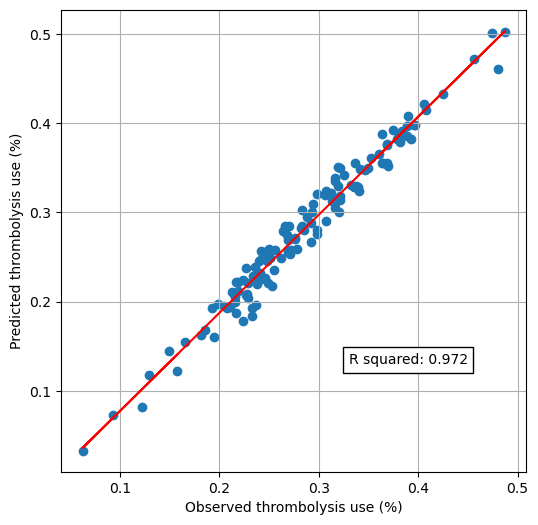

In [20]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax1.scatter(x_comparision,
            y_comparision)

plt.plot (x_comparision, slr.predict(x_comparision), color = 'red')
text = f'R squared: {r_square:.3f}'
ax1.text(0.33,0.13, text, 
         bbox=dict(facecolor='white', edgecolor='black'))
ax1.set_xlabel('Observed thrombolysis use (%)')
ax1.set_ylabel('Predicted thrombolysis use (%)')
plt.grid()
plt.savefig(f'output/{model_type}_observed_predicted_rates.jpg', dpi=300)
plt.show()

## Feature Importances

Get XGBoost feature importances (average across k-fold results)

In [21]:
# Feature names
features = X_test.columns.values

# Get average feature importance from k-fold
importances = np.array(feature_importance).mean(axis = 0)
feature_importance = pd.DataFrame(data = importances, index=features)
feature_importance.columns = ['importance']

# Sort by importance (weight)
feature_importance.sort_values(by='importance', ascending=False, inplace=True)

# Save
feature_importance.to_csv(f'output/{model_type}_feature_importance.csv')

# Display top 25
feature_importance.head(25)

,importance
Infarction,0.373361
Use of AF anticoagulents,0.040884
Precise onset time,0.029493
Arrival-to-scan time,0.012430
team_MHMYL4920B,0.011786
team_GKONI0110I,0.011675
Stroke severity,0.010857
team_QWKRA8499D,0.010189
Prior disability level,0.010078
team_LECHF1024T,0.009767


Create a bar chart for the XGBoost feature importance values

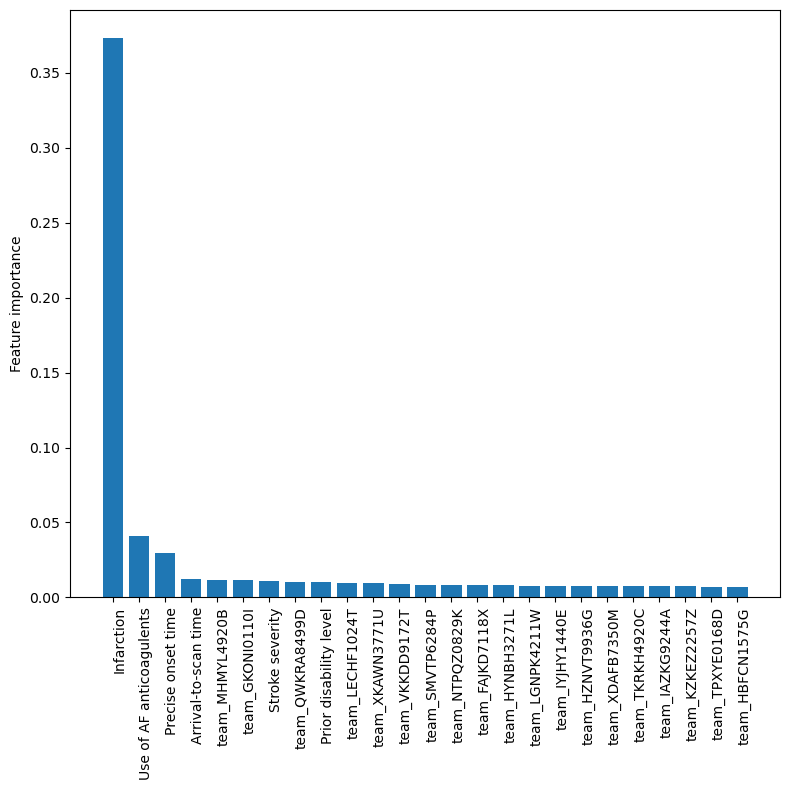

In [22]:
# Set up figure
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

# Get labels and values
labels = feature_importance.index.values[0:25]
pos = np.arange(len(labels))
val = feature_importance['importance'].values[0:25]

# Plot
ax.bar(pos, val)
ax.set_ylabel('Feature importance')
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")

plt.tight_layout()
plt.savefig(f'output/{model_type}_feature_weights_bar.jpg', dpi=300)
plt.show()

## Calibration and assessment of accuracy when model has high confidence

In [23]:
# Collate results in Dataframe
reliability_collated = pd.DataFrame()

# Loop through k fold predictions
for i in range(5):
    
    # Get observed class and predicted probability
    obs = observed[i]
    prob = predicted_proba[i]
    
    # Bin data with numpy digitize (this will assign a bin to each case)
    step = 0.10
    bins = np.arange(step, 1+step, step)
    digitized = np.digitize(prob, bins)
        
    # Put single fold data in DataFrame
    reliability = pd.DataFrame()
    reliability['bin'] = digitized
    reliability['probability'] = prob
    reliability['observed'] = obs
    classification = 1 * (prob > 0.5 )
    reliability['correct'] = obs == classification
    reliability['count'] = 1
    
    # Summarise data by bin in new dataframe
    reliability_summary = pd.DataFrame()

    # Add bins and k-fold to summary
    reliability_summary['bin'] = bins
    reliability_summary['k-fold'] = i

    # Calculate mean of predicted probability of thrombolysis in each bin
    reliability_summary['confidence'] = \
        reliability.groupby('bin').mean()['probability']

    # Calculate the proportion of patients who receive thrombolysis
    reliability_summary['fraction_positive'] = \
        reliability.groupby('bin').mean()['observed']
    
    # Calculate proportion correct in each bin
    reliability_summary['fraction_correct'] = \
        reliability.groupby('bin').mean()['correct']
    
    # Calculate fraction of results in each bin
    reliability_summary['fraction_results'] = \
        reliability.groupby('bin').sum()['count'] / reliability.shape[0]   
    
    # Add k-fold results to DatafRame collation
    reliability_collated = reliability_collated.append(reliability_summary)
    
# Get mean results
reliability_summary = reliability_collated.groupby('bin').mean()
reliability_summary.drop('k-fold', axis=1, inplace=True)

In [24]:
reliability_summary

,confidence,fraction_positive,fraction_correct,fraction_results
bin,,,,
0.1,0.018516,0.023629,0.976371,0.473196
0.2,0.145986,0.166897,0.833103,0.084433
0.3,0.247415,0.264822,0.735178,0.058080
0.4,0.348503,0.363140,0.636860,0.047921
0.5,0.449472,0.446929,0.553071,0.043450
0.6,0.549958,0.547623,0.547623,0.043315
0.7,0.651549,0.640677,0.640677,0.050421
0.8,0.753154,0.737548,0.737548,0.065389
0.9,0.851711,0.828125,0.828125,0.088037


Plot results:

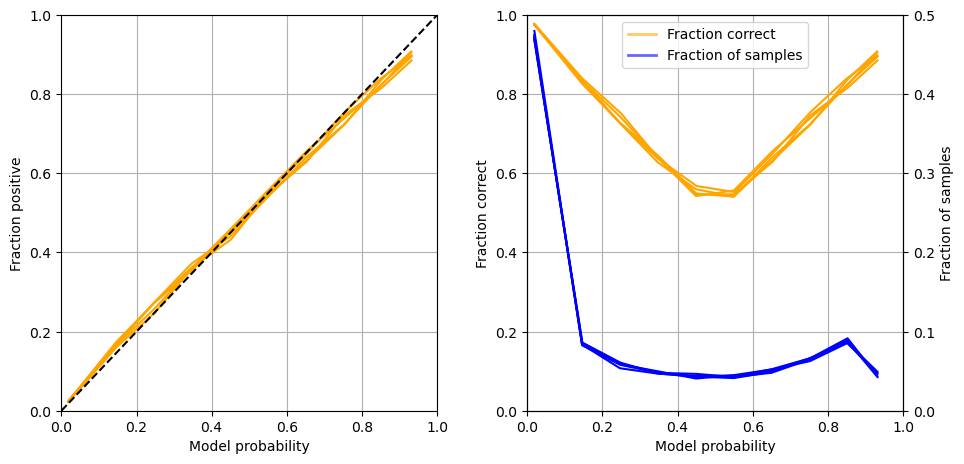

In [25]:
fig = plt.figure(figsize=(10,5))

# Plot predicted prob vs fraction psotive
ax1 = fig.add_subplot(1,2,1)

# Loop through k-fold reliability results
for i in range(5):
    mask = reliability_collated['k-fold'] == i
    k_fold_result = reliability_collated[mask]
    x = k_fold_result['confidence']
    y = k_fold_result['fraction_positive']
    ax1.plot(x,y, color='orange')
# Add 1:1 line
ax1.plot([0,1],[0,1], color='k', linestyle ='--')
# Refine plot
ax1.set_xlabel('Model probability')
ax1.set_ylabel('Fraction positive')
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)

# Plot accuracy vs probability
ax2 = fig.add_subplot(1,2,2)
# Loop through k-fold reliability results
for i in range(5):
    mask = reliability_collated['k-fold'] == i
    k_fold_result = reliability_collated[mask]
    x = k_fold_result['confidence']
    y = k_fold_result['fraction_correct']
    ax2.plot(x,y, color='orange')
# Refine plot
ax2.set_xlabel('Model probability')
ax2.set_ylabel('Fraction correct')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)

# instantiate a second axes that shares the same x-axis
ax3 = ax2.twinx()  
for i in range(5):
    mask = reliability_collated['k-fold'] == i
    k_fold_result = reliability_collated[mask]
    x = k_fold_result['confidence']
    y = k_fold_result['fraction_results']
    ax3.plot(x,y, color='blue')
    
ax3.set_xlim(0, 1)
ax3.set_ylim(0, 0.5)
ax3.set_ylabel('Fraction of samples')

custom_lines = [Line2D([0], [0], color='orange', alpha=0.6, lw=2),
                Line2D([0], [0], color='blue', alpha = 0.6,lw=2)]

ax1.grid()
ax2.grid()

plt.legend(custom_lines, ['Fraction correct', 'Fraction of samples'],
          loc='upper center')

plt.tight_layout(pad=2)

plt.savefig(f'./output/{model_type}_reliability.jpg', dpi=300)
plt.show()

Get accuracy of model when model is at least 80% confident

In [26]:
bins = [0.1, 0.2, 0.9, 1.0]
acc = reliability_summary.loc[bins].mean()['fraction_correct']
frac = reliability_summary.loc[bins].sum()['fraction_results']

print ('For samples with at least 80% confidence:')
print (f'Proportion of all samples: {frac:0.3f}')
print (f'Accuracy: {acc:0.3f}')

For samples with at least 80% confidence:
Proportion of all samples: 0.691
Accuracy: 0.884


## Check for predicted thrombolysis in test set 

In [27]:
mask = combined_test_set['Infarction'] == 0
haemorrhagic_test = model_predictions['predicted'][mask]

In [28]:
count = len(haemorrhagic_test)
pos = haemorrhagic_test.sum()
print (f'{pos:.0f} predicted thrombolysis out of {count} haemorrhagic strokes')

0 predicted thrombolysis out of 13243 haemorrhagic strokes


## Learning curve

Examine the relationship between training data size and accuracy.

Plot learning curve

In [29]:
# Set up list to collect results
results_training_size = []
results_accuracy = []
results_all_accuracy = []

# Get maximum training size (number of training records)
max_training_size = train_data[0].shape[0]

# Construct training sizes (values closer at lower end)
train_sizes = [50, 100, 250, 500, 1000, 2500]
for i in range (5000, max_training_size, 5000):
    train_sizes.append(i)

# Loop through training sizes
for train_size in train_sizes:
    
    # Record accuracy across k-fold replicates
    replicate_accuracy = []

    for replicate in range(5):
        
        # Get training and test data (from first k-fold split)
        train = train_data[0]
        test = test_data[0]
        
        # One hot encode hospitals
        train_hosp = pd.get_dummies(train['Stroke team'], prefix = 'team')
        train = pd.concat([train, train_hosp], axis=1)
        train.drop('Stroke team', axis=1, inplace=True)
        test_hosp = pd.get_dummies(test['Stroke team'], prefix = 'team')
        test = pd.concat([test, test_hosp], axis=1)
        test.drop('Stroke team', axis=1, inplace=True) 
        
        # Sample from training data
        train = train.sample(n=train_size)

        # Get X and y
        X_train = train.drop('Thrombolysis', axis=1)
        X_test = test.drop('Thrombolysis', axis=1)
        y_train = train['Thrombolysis']
        y_test = test['Thrombolysis']        
       
        # Define model
        model = XGBClassifier(verbosity = 0, seed=42, learning_rate=0.5)

        # Fit model
        model.fit(X_train, y_train)

        # Predict test set
        y_pred_test = model.predict(X_test)

        # Get accuracy and record results
        accuracy = np.mean(y_pred_test == y_test)
        replicate_accuracy.append(accuracy)
        results_all_accuracy.append(accuracy)
    
    # Store mean accuracy across the k-fold splits
    results_accuracy.append(np.mean(replicate_accuracy))
    results_training_size.append(train_size)

k_fold_accuracy = np.array(results_all_accuracy).reshape(len(train_sizes), 5)

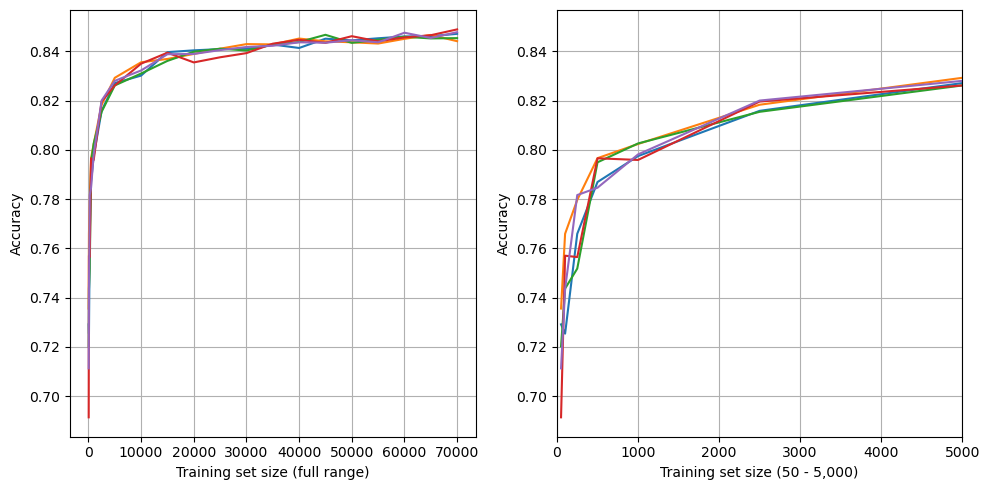

In [30]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)

for i in range(5):
    ax1.plot(results_training_size, k_fold_accuracy[:, i])

ax1.set_xlabel('Training set size (full range)')
ax1.set_ylabel('Accuracy')
ax1.grid()

# Focus on first 5000
ax2 = fig.add_subplot(122)
for i in range(5):
    ax2.plot(results_training_size, k_fold_accuracy[:, i])

ax2.set_xlabel('Training set size (50 - 5,000)')
ax2.set_ylabel('Accuracy')
ax2.set_xlim(0, 5000)
ax2.grid()

plt.tight_layout()
plt.savefig(f'./output/{model_type}_learning_curve.jpg', dpi=300)
plt.show()

## Observations

* Overall accuracy = 84.8% (88.3 for those 69% samples with at least 80% confidence of model)
* Using nominal threshold (50% probability), specificity (89.4%) is greater than sensitivity (73.8%)
* The model can achieve 83.8% sensitivity and specificity simultaneously
* ROC AUC = 0.916
* The model is well calibrated